In [0]:
# Install pyspark and initiate
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.6.tgz
!tar xf spark-2.4.5-bin-hadoop2.6.tgz
!pip install -q findspark

In [0]:
#Envirnoment set up
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.6"

In [0]:
#Spark session creation
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
#Import libraries
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.recommendation import Rating


# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#Creating an object to run SparkContext and configuration parameters set up
sc = spark.sparkContext
spark.conf.set("spark.executor.memory", '8g')
spark.conf.set('spark.executor.cores', '3')
spark.conf.set('spark.cores.max', '3')
spark.conf.set("spark.driver.memory",'8g')

In [6]:
#Drive mounting 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 1. Load the RDD Dataset

In [0]:
ratings = sc.textFile('/content/drive/My Drive/als_preprocessed1.csv')

# preprocess data -- only need ["userId", "movieId", "rating"]
header = ratings.take(1)[0]
ratingsRDD = ratings \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda p: Rating(user = int(p[0]), 
                          product = int(p[1]),
                          rating = float(p[2]), 
                          )).cache()

### 2. Visualizations on subset of ratings matrix

We will consider subset of data. Taking only 100 users and 100 products for visualizations.


In [0]:
ratings = ratingsRDD.filter(lambda x: x.user < 100 and x.product < 100)

In [178]:
ratingsRDD.take(10)

[Rating(user=19236, product=26144, rating=5.0),
 Rating(user=48511, product=32800, rating=5.0),
 Rating(user=3549, product=18426, rating=5.0),
 Rating(user=57166, product=27789, rating=5.0),
 Rating(user=44574, product=2863, rating=5.0),
 Rating(user=42775, product=32316, rating=4.0),
 Rating(user=25519, product=20337, rating=5.0),
 Rating(user=51897, product=16917, rating=3.0),
 Rating(user=47404, product=32845, rating=4.0),
 Rating(user=45738, product=11341, rating=5.0)]

In [179]:
ratings.toDF().describe().show()

+-------+-----------------+------------------+------------------+
|summary|             user|           product|            rating|
+-------+-----------------+------------------+------------------+
|  count|               14|                14|                14|
|   mean|51.92857142857143|46.785714285714285| 4.428571428571429|
| stddev|34.33424907203679| 28.91147914537799|0.9376144618769908|
|    min|                1|                 3|               2.0|
|    max|               99|                93|               5.0|
+-------+-----------------+------------------+------------------+



In [0]:
user = ratings.map(lambda x: int(x.user)).cache()
movie = ratings.map(lambda x: int(x.product)).cache()

In [0]:
min_r = 2.0
max_r = 5.0

Normalizing the rating values for all users to get color definitions

In [0]:
def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratings.map(lambda x: normalise(x.rating)).cache()

We use matplolib to analyze the users and products ratings. We can visualize the sparse matrix.

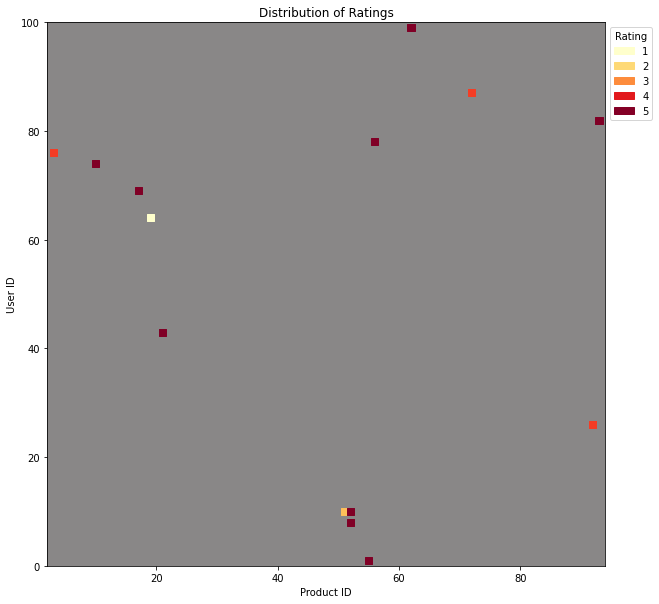

In [183]:
min_user = 1
max_user = 99
min_movie = 3
max_movie = 93

plt.figure(figsize=(10,10))
plt.ylim([min_user-1,max_user+1])
plt.xlim([min_movie-1,max_movie+1])
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.title('Distribution of Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    movie.collect(), 
    user.collect(), 
    s=50,
    marker="s",
    color=colors,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

In this plot, we can see different ratings with different color code. For example User 20 has rated movie 40 with the highest rating of 5.
Let's group the data to cross-verify

In [184]:
ratings.collect()

[Rating(user=99, product=62, rating=5.0),
 Rating(user=76, product=3, rating=4.0),
 Rating(user=69, product=17, rating=5.0),
 Rating(user=8, product=52, rating=5.0),
 Rating(user=78, product=56, rating=5.0),
 Rating(user=74, product=10, rating=5.0),
 Rating(user=10, product=51, rating=3.0),
 Rating(user=87, product=72, rating=4.0),
 Rating(user=43, product=21, rating=5.0),
 Rating(user=26, product=92, rating=4.0),
 Rating(user=1, product=55, rating=5.0),
 Rating(user=82, product=93, rating=5.0),
 Rating(user=64, product=19, rating=2.0),
 Rating(user=10, product=52, rating=5.0)]

### 3. Visualizations on full data of ratings matrix

We plot for the entire data now. Considering all users and products.

In [186]:
ratingsRDD.take(20)

[Rating(user=19236, product=26144, rating=5.0),
 Rating(user=48511, product=32800, rating=5.0),
 Rating(user=3549, product=18426, rating=5.0),
 Rating(user=57166, product=27789, rating=5.0),
 Rating(user=44574, product=2863, rating=5.0),
 Rating(user=42775, product=32316, rating=4.0),
 Rating(user=25519, product=20337, rating=5.0),
 Rating(user=51897, product=16917, rating=3.0),
 Rating(user=47404, product=32845, rating=4.0),
 Rating(user=45738, product=11341, rating=5.0),
 Rating(user=20698, product=15602, rating=2.0),
 Rating(user=47683, product=10177, rating=5.0),
 Rating(user=19478, product=25445, rating=5.0),
 Rating(user=51606, product=21690, rating=4.0),
 Rating(user=30085, product=24265, rating=5.0),
 Rating(user=18681, product=34575, rating=4.0),
 Rating(user=2418, product=10177, rating=5.0),
 Rating(user=41667, product=16195, rating=1.0),
 Rating(user=2735, product=21269, rating=5.0),
 Rating(user=11516, product=25031, rating=5.0)]

In [187]:
ratingsRDD.toDF().describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|           product|            rating|
+-------+------------------+------------------+------------------+
|  count|             60605|             60605|             60605|
|   mean|27326.114941011467|11216.088936556389| 4.370249979374639|
| stddev|17257.391764705255|10675.507882298809|1.1197738540168996|
|    min|                 0|                 0|               1.0|
|    max|             57477|             34860|               5.0|
+-------+------------------+------------------+------------------+



In [0]:
user = ratingsRDD.map(lambda x: int(x.user)).cache()
movie = ratingsRDD.map(lambda x: int(x.product)).cache()

In [0]:
min_r = 1.0
max_r = 5.0

In [0]:
def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratingsRDD.map(lambda x: normalise(x.rating)).cache()

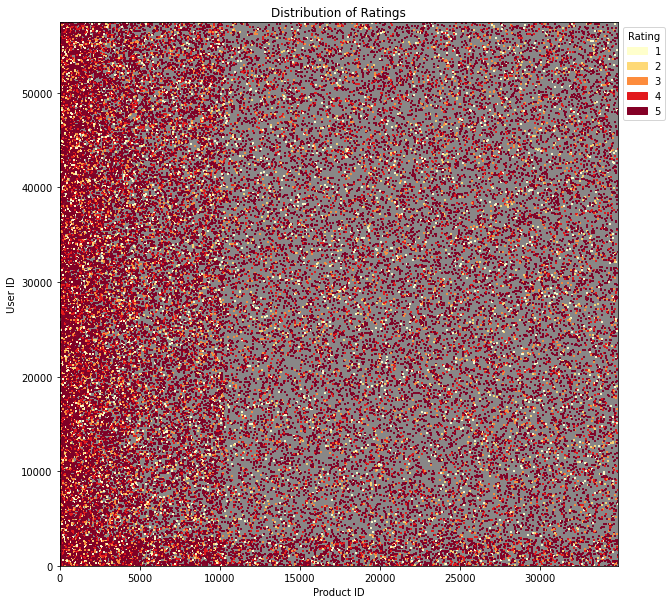

In [192]:
min_user = 0
max_user = 57477
min_movie = 0
max_movie = 34860

plt.figure(figsize=(10,10))
plt.ylim([min_user-1,max_user+1])
plt.xlim([min_movie-1,max_movie+1])
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.title('Distribution of Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    movie.collect(), 
    user.collect(), 
    s=1,
    marker="s",
    color=colors,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

We can see some clear patterns. The vertical lines indicate that the products are rated similarly by all users.
The horizontal lines could also indicate that a person ranks all products fairly similarly - if a pale line, they tend to rate negatively and dark red positively.
There are some interesting grey patterns too, where users have not rated products at all. 

We can also notice that some products have dense ratings, indicating some of the popular/regularly purchased products.
  > 1. The left part of the graph indicated highly purchased/ordered products
  > 2. Grey parts indicating no ratings for those products